In [ ]:
# pip install fiftyone scipy lancedb 

In [1]:
import fiftyone as fo
import fiftyone.utils.huggingface as fouh

# Load the dataset from Hugging Face if it's your first time using it

# dataset = fouh.load_from_hub(
#     "Voxel51/Coursera_lecture_dataset_train", 
#     dataset_name="lecture_dataset_train", 
#     persistent=True
#     )

In [2]:
#because I have the dataset saved locally, I will load it like so
cloned_dataset = fo.load_dataset("lecture_dataset_train_clone")

In [3]:
import cv2
import numpy as np
from scipy.ndimage import label
from scipy.spatial.distance import pdist

### Image complexity

We can use Canny edge detection to measure the ratio of edge pixels to total pixels

This metric can be useful because:

1. It provides a measure of the level of detail and intricacy in an image.

2. Higher complexity can indicate more challenging images for object detection.

3. It can help identify images that might require more processing power or sophisticated algorithms for accurate analysis.

4. Understanding image complexity can aid in balancing datasets and evaluating model performance across different complexity levels.


#### Limitations

- **Oversimplification:** Edge detection reduces an image to binary information (edge or non-edge), discarding valuable texture and color information that could be crucial for object detection.

- **Sensitivity to Noise:** Canny edge detection can be sensitive to image noise, potentially leading to inaccurate complexity assessments in noisy images.

- **Parameter Dependency:** The effectiveness of Canny edge detection heavily relies on the chosen threshold parameters (100 and 200 in this case), which may not be optimal for all images in a diverse dataset.

In [4]:
def calculate_image_complexity(dataset):
    """
    Calculate the complexity of images in a FiftyOne dataset using Canny edge detection and color information.

    Parameters:
    dataset (fiftyone.core.dataset.Dataset): FiftyOne dataset object.

    Returns:
    None. It just adds the field to the dataset
    """
    for sample in dataset.iter_samples():
        img = cv2.imread(sample.filepath)
        # Convert the image to float32
        img_float = img.astype(np.float32) / 255.0
        # Calculate the color variance for the image
        color_variance = np.var(img_float, axis=(0, 1)).sum()
        # Convert to grayscale for edge detection
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        edge_complexity = np.sum(edges > 0) / (img.shape[0] * img.shape[1])
        # Combine edge complexity and color variance
        complexity = edge_complexity + color_variance
        sample["image_complexity_score"] = complexity
        sample.save()

In [5]:
calculate_image_complexity(cloned_dataset)

In [ ]:
fo.launch_app(cloned_dataset)

### Visual clutter 

Calculates the variance of pixel intensities in the image.

This metric is useful because:

1. It measures the level of disorder or chaos in an image, which can impact object detection.

2. High visual clutter can make it more difficult to isolate and identify individual objects.

3. It provides insight into the visual complexity of scenes beyond just object count or density.

4. Understanding visual clutter can help in developing strategies to improve model performance on visually complex images.

#### Limitations

- **Oversimplification:** Reducing visual clutter to a single variance value may oversimplify the concept, missing important spatial relationships.

- **Grayscale Conversion:** Converting to grayscale loses color information, which can be a significant factor in visual clutter and object detection.

- **Global Measure:** The global variance doesn't capture local variations in clutter, which might be more relevant for object detection.

- **Insensitivity to Structure:** High variance doesn't necessarily correlate with difficulty in object detection. A highly structured image could have high variance but be relatively easy for object detection.

In [7]:
def calculate_visual_clutter(dataset):
    """
    Calculate the visual clutter of images in a FiftyOne dataset using pixel intensity variance and color variance.

    Parameters:
    dataset (fiftyone.core.dataset.Dataset): FiftyOne dataset object.

    Returns:
    None. It just adds the field to the dataset.
    """
    for sample in dataset.iter_samples():
        img = cv2.imread(sample.filepath)
        
        # Calculate grayscale variance
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_clutter = np.var(gray)
        
        # Calculate color variance
        img_float = img.astype(np.float32) / 255.0  # Convert to float32
        color_variance = np.var(img_float, axis=(0, 1)).sum()
        
        # Combine both measures
        clutter = gray_clutter + color_variance
        sample["visual_clutter_score"] = clutter
        sample.save()

In [8]:
calculate_visual_clutter(cloned_dataset)

In [ ]:
fo.launch_app(cloned_dataset)

### Object Clutter

An object clutter score will identify number of detections per image. This is a simple and useful metric. It provides a quick measure of how busy or crowded an image is in terms of objects.

This metric is useful because:

1. It provides a simple measure of scene complexity in terms of object count.

2. Higher clutter scores can indicate more challenging images for object detection.

3. It helps identify images that may require more processing time or have higher chances of false positives/negatives.

4. Understanding clutter can aid in balancing datasets and evaluating model performance across different complexity levels.

**Pros:**

- Easy to calculate and interpret

- Gives a clear indication of image complexity

**Cons:**

- Doesn't account for object size or distribution

- May not distinguish between genuinely cluttered scenes and scenes with many small objects

**Usefulness:** High, especially as a basic measure of image complexity.

In [10]:
from fiftyone import ViewField as F

detection_counts = cloned_dataset.values(F("ground_truth.detections").length())

cloned_dataset.set_values("object_clutter_score", detection_counts)

In [ ]:
fo.launch_app(cloned_dataset)

### Object diversity

This will measure the number of distinct classes per image. This is an excellent metric for measuring the semantic diversity of an image.

This metric is useful because:

1. It quantifies the variety of object types present in an image.

2. Higher diversity can indicate more complex scenes that require broader object recognition capabilities.

3. It helps in assessing the range of objects a model needs to handle within a single image.

4. Understanding instance diversity can guide dataset curation to ensure a wide range of object combinations are represented.

**Pros:**

- Directly measures the variety of object types in an image

- Easy to calculate and interpret

**Cons:**

- Doesn't account for the number of instances of each class

- Treats all classes equally, regardless of their visual or semantic similarity

**Usefulness:** High, particularly for understanding the range of objects a model needs to handle.

---
Note: Below we're using `$` in the ViewField. The "$" in FiftyOne is like an "absolute path" in file systems.

- Without "$": Relative path. Depends on where you are in the data structure.

- With "$": Absolute path. Always starts from the root of each sample.

Use "$" when:

1. In complex queries where context might be ambiguous
2. Inside operations like map() or reduce()
3. You want to be explicitly clear you're referring to a top-level field

You often don't need "$" for simple, top-level queries.

In this case, `F("$ground_truth.detections.label")` ensures you're accessing the correct data structure (the top-level `ground_truth` field), and prevents FiftyOne from mistakenly operating on a string instead of an array.

In [12]:
from fiftyone import ViewField as F

object_diversity_expression = F("$ground_truth.detections.label").unique().length()

object_diversity_scores = cloned_dataset.values(object_diversity_expression)

cloned_dataset.set_values("object_diversity_score", object_diversity_scores)

In [ ]:
cloned_dataset.first()

In [ ]:
fo.launch_app(cloned_dataset)

###  Diversity Ratio

This metric considers the number of detections and number of classes per image. This is a more nuanced approach to measuring diversity that takes into account both the number of objects and the variety of classes.

This metric is useful because:

1. It balances the number of objects with the variety of object types, providing a more nuanced view of image complexity.

2. It can distinguish between images with many objects of few classes and those with fewer objects but more diverse classes.

3. Higher ratios might indicate images that could present challenges to an object detection system.

4. This metric can help in creating balanced datasets that challenge models in different ways.

I'm using `log10(object_clutter) + 1` in the denominator to put more emphasis on the number of unique classes relative to the total number of detections. This aim is to highlight images with a diverse range of object classes even if they don't have an extremely high number of total detections.

**Pros:**

- Combines quantity and variety of objects

- Can distinguish between images with many objects of few classes and those with fewer objects but more classes

**Cons:**

- May require careful design to balance the influence of object count and class count

- Interpretation might be less intuitive than simpler metrics

**Usefulness:** High, as it provides a more comprehensive view of image complexity.

In [15]:
from fiftyone import ViewField as F

diversity_expression = F("object_diversity_score") / (F("object_clutter_score").log10() + 1)

diversity_ratios = cloned_dataset.values(diversity_expression)

cloned_dataset.set_values("diversity_ratio", diversity_ratios)

In [ ]:
fo.launch_app(cloned_dataset)

### Objectness score 

This metric measures the percentage of pixels that belong to classes across the whole image. Basically what percentage of the pixels contains a detection.

1. It provides insight into how much of the image is occupied by objects of interest.

2. Lower scores might indicate images with large background areas or small objects, which can be challenging for detection.

3. It can help identify images where objects occupy a significant portion of the scene, potentially affecting detection strategies.

4. Understanding objectness can aid in analyzing model performance relative to object size and prominence in the image.

This is a valuable metric for understanding how much of the image is occupied by objects of interest.

**Pros:**
- Provides insight into the density of annotated objects
- Can help identify images with large background areas

**Cons:**
- Doesn't account for the number or diversity of objects
- May be biased towards images with large objects

**Usefulness:** High, especially when combined with other metrics.

In [17]:
from fiftyone import ViewField as F

rel_bbox_area = F("bounding_box")[2] * F("bounding_box")[3]

im_width, im_height = F("$metadata.width"), F("$metadata.height")

abs_area = rel_bbox_area * im_width * im_height

cloned_dataset.set_field("ground_truth.detections.relative_bbox_area", rel_bbox_area).save()

cloned_dataset.set_field("ground_truth.detections.absolute_bbox_area", abs_area).save()

In [18]:
objectness_scores = cloned_dataset.values(F("$ground_truth.detections.relative_bbox_area").sum())

cloned_dataset.set_values("objectness_score", objectness_scores)

In [ ]:
fo.launch_app(cloned_dataset)

### Spatial Distribution Score

This metric measures how spread out the detected objects are across the image space. It can be calculated using various methods, such as the average distance between object centers or the standard deviation of object positions. 

A high spatial distribution score indicates that objects are well spread out across the image, which could be beneficial for training models to detect objects in various image locations. Conversely, a low score might indicate clustering of objects in certain areas of the image.


This metric is useful because:

1. It quantifies how spread out or clustered objects are within an image.

2. Images with more evenly distributed objects might present different challenges than those with clustered objects.

3. It can help identify images where objects are tightly grouped, which might be challenging for object separation.

4. Understanding spatial distribution can aid in developing models that perform well across various object arrangements.

In [ ]:
bounding_box_centroid = (
    (F("bounding_box")[0] + F("bounding_box")[2]/2),
    (F("bounding_box")[1] + F("bounding_box")[3]/2)
    )

cloned_dataset.set_field("ground_truth.detections.bbox_centroid", bounding_box_centroid).save()

centroids = cloned_dataset.values("ground_truth.detections.bbox_centroid")

averaege_pair_wise_distances = [np.mean(pdist(c)) if len(c) > 0 else 0 for c in centroids]

cloned_dataset.set_values("spatial_distribution_score", averaege_pair_wise_distances)

In [ ]:
fo.launch_app(cloned_dataset)

### Using zero shot models to get scene info

You can also use a CLIP model to classify the scene type of an image. 

In [22]:
import fiftyone.zoo as foz
import os 
# Make zero-shot predictions with custom classes

clip_model = foz.load_zoo_model(
    "clip-vit-base32-torch",
    text_prompt="A picture of a ",
    classes=[
        "indoor scene", 
        "sporting event", 
        "outdoor scene", 
        "nature scene",
        "urban scene",
        "urban street view",
        "food",
        "snow covered scene",
        ],
        # device="cuda", # if you're using on a GPU
)

cloned_dataset.apply_model(
    model = clip_model, 
    label_field="scene_type",
    batch_size=128, # depeding on the memory of your machine
    num_workers=os.cpu_count(), # depending on the number of cores in your machine
    )

 100% |█████████████| 16508/16508 [7.0m elapsed, 0s remaining, 38.3 samples/s]    


In [ ]:
fo.launch_app(cloned_dataset)

### Semantic search over dataset

You can also use a CLIP model to build a similarity index over the dataset so that you can search your dataset with text queries. You can also visualize the embeddings from the CLIP model. They'll be different from the embeddings we saw in the previous lesson as they capture more semantic information about an image.

In [24]:
import fiftyone.brain as fob
import fiftyone.zoo as foz
import os 

clip_model = foz.load_zoo_model(
    "clip-vit-base32-torch",
    # device="cuda", # if you're using on a GPU
    )

clip_embeddings = cloned_dataset.compute_embeddings(
    model= clip_model,
    embeddings_field="clip_embeddings",
    batch_size=128,
    num_workers=os.cpu_count(),
    progress=True,
    
)

clip_viz = fob.compute_visualization(
    samples=cloned_dataset,
    embeddings="clip_embeddings",    
    method="umap",
    brain_key="clip_viz",
    num_dims=2,
    batch_size=128,
    num_workers=os.cpu_count(),
)

clip_sim_index = fob.compute_similarity(
    samples=cloned_dataset,
    model= "clip-vit-base32-torch",
    embeddings="clip_embeddings",
    brain_key="clip_sim",
    num_workers=os.cpu_count(),
    metric="cosine",
    backend="lancedb", #make sure you have lancedb installed `pip install lancedb`
)

 100% |█████████████| 16508/16508 [7.5m elapsed, 0s remaining, 36.1 samples/s]     
Generating visualization...
UMAP( verbose=True)
Tue Sep 10 12:18:30 2024 Construct fuzzy simplicial set
Tue Sep 10 12:18:30 2024 Finding Nearest Neighbors
Tue Sep 10 12:18:30 2024 Building RP forest with 11 trees
Tue Sep 10 12:18:32 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Tue Sep 10 12:18:38 2024 Finished Nearest Neighbor Search
Tue Sep 10 12:18:39 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Sep 10 12:18:47 2024 Finished embedding


[2024-09-10T17:18:48Z WARN  lance::dataset] No existing dataset at /tmp/lancedb/fiftyone-lecture-dataset-train-clone.lance, it will be created



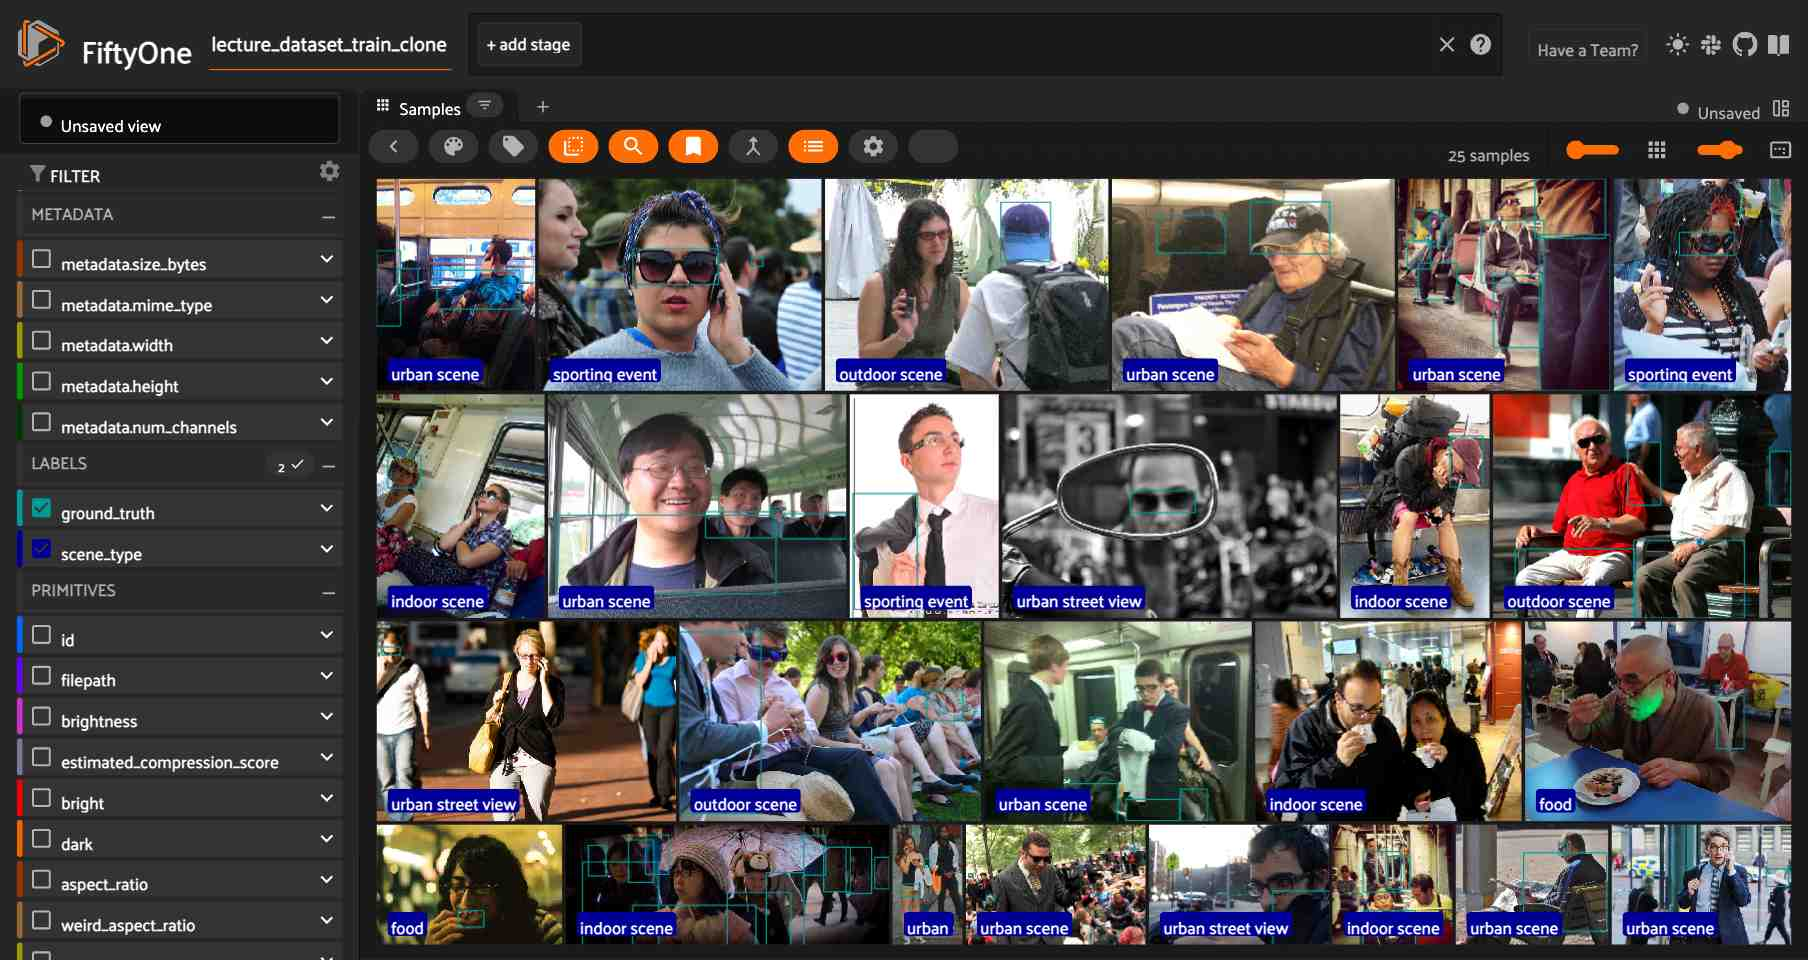

Dataset:          lecture_dataset_train_clone
Media type:       image
Num samples:      16508
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [26]:
fo.launch_app(cloned_dataset)

In [27]:
glasses_view = clip_sim_index.sort_by_similarity(query="people wearing glasses")


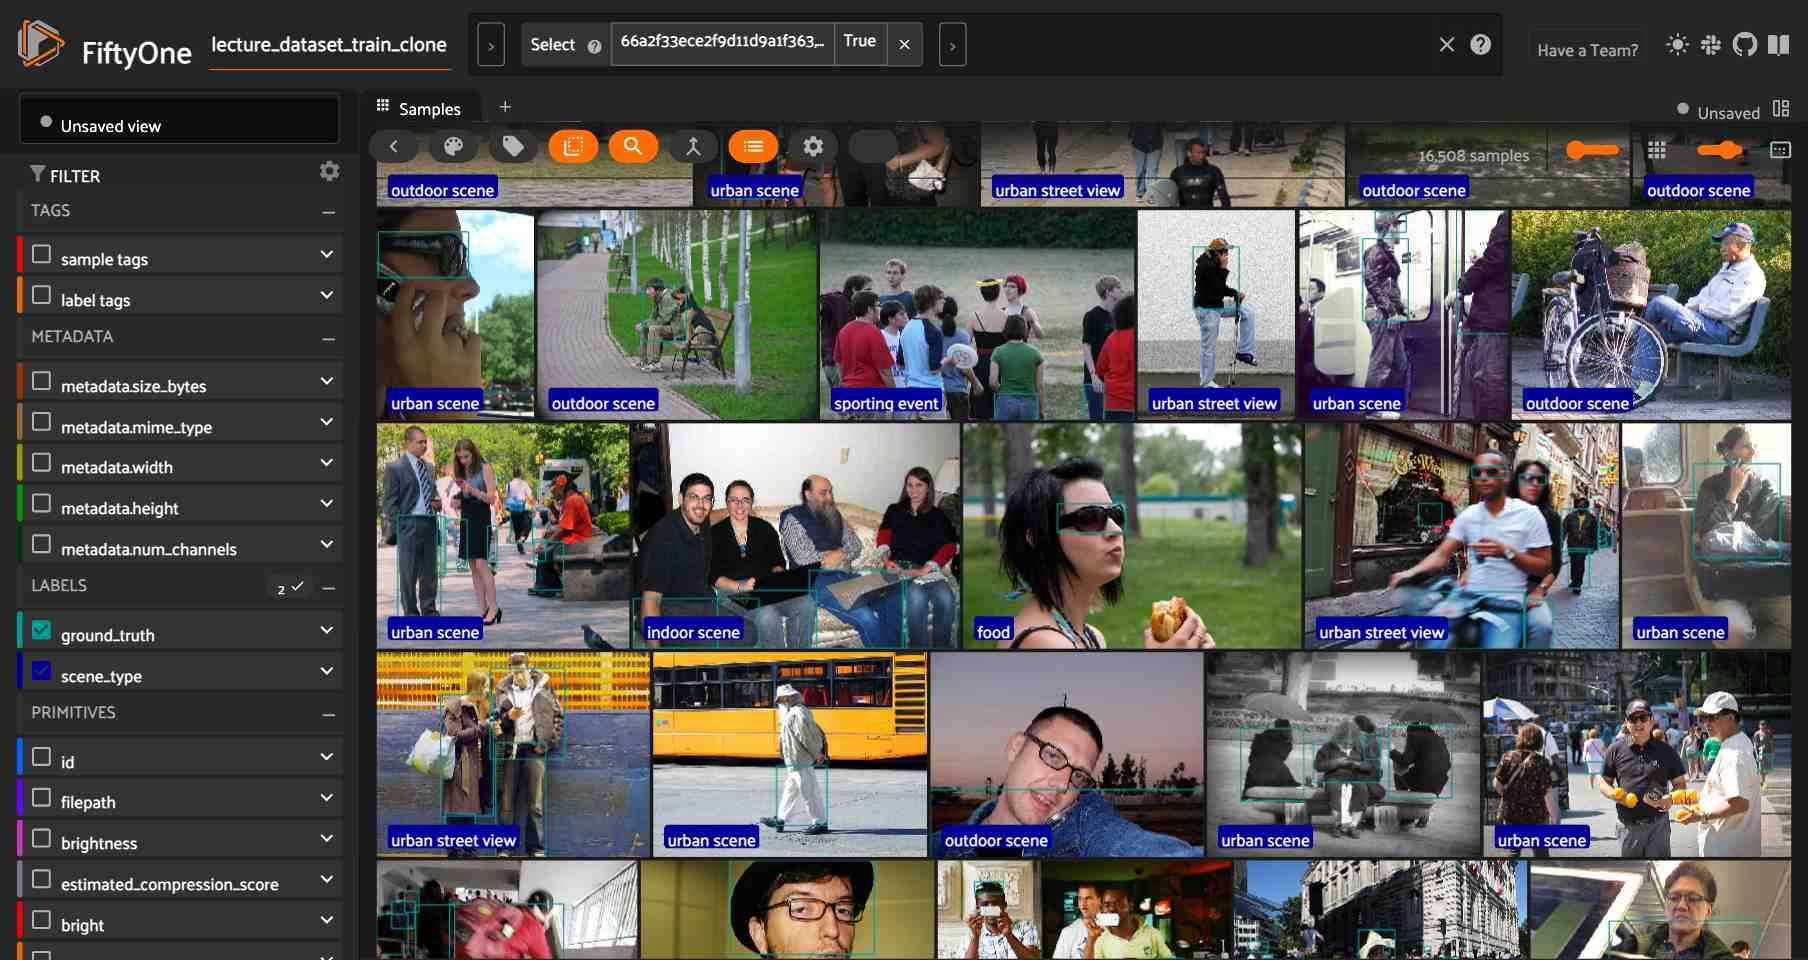

Dataset:          lecture_dataset_train_clone
Media type:       image
Num samples:      16508
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/
View stages:
    1. Select(sample_ids=['66a2f33ece2f9d11d9a1f363', '66a2f2dace2f9d11d9a123f5', '66a2f34dce2f9d11d9a21934', ...], ordered=True)

In [28]:
fo.launch_app(glasses_view)

# Image representativeness

During the early stages of the ML workflow it can be useful to find prototypical samples in your data that accurately describe all the different aspects of your data. FiftyOne Brain provides a representativeness method that finds samples which are very similar to large clusters of your data. Highly representative samples are great for finding modes or easy examples in your dataset. Here's some ideas for ways you may want to make use of the [`compute_representativeness`](https://docs.voxel51.com/api/fiftyone.brain.html#fiftyone.brain.compute_representativeness) method:

- Samples with low representativeness scores may indicate outliers or unusual cases in your dataset. This can help identify potential data quality issues or interesting edge cases.

- Samples with high representativeness scores could be good candidates for data augmentation, as they likely represent typical cases in your dataset

- During testing, you could use the representativeness scores to assess how well your model performs on typical vs. atypical samples

- In scenarios where you're actively labeling data, you could prioritize labeling samples with varying representativeness scores to ensure a diverse set of labeled examples

- By monitoring the distribution of representativeness scores over time, you might be able to detect shifts in your data distribution


### Here's how it works:

- **Input**: An unlabeled (or labeled) image dataset.

- **Output**: A scalar-valued representativeness field is populated for each sample that ranks the representativeness of that sample (higher value means more representative). The representativeness values for a dataset are normalized to [0, 1], with the most representative samples in the collection having a representativeness value of 1.

- **Under the hood**: Representativeness uses a clustering algorithm to find similar looking groups of samples. The representativeness is then computed based on each sample’s proximity to the computed cluster centers, farther samples being less representative and closer samples being more representative. You can change the method to compute the representativeness by passing in a supported value into the `method` argument. The supported values are ["cluster-center", 'cluster-center-downweight']. 
  -  `"cluster-center"` (default) will make a sample's representativeness proportional to it's proximity to cluster centers
  -  `"cluster-center-downweight"` will ensure more diversity in representative samples

If no  `embeddings` or `model` is provided, a default model is used to generate embeddings.

The representativeness of a Dataset can be computed directly without the need for the predictions of a pre-trained model via the [`compute_representativeness`](https://docs.voxel51.com/api/fiftyone.brain.html#fiftyone.brain.compute_representativeness) method:

In [25]:
import fiftyone as fo
import fiftyone.brain as fob

fob.compute_representativeness(
    cloned_dataset,
    embeddings="clip_embeddings",
    )

Computing representativeness...
Computing clusters for 16508 embeddings; this may take awhile...
Representativeness computation complete


In [29]:
fo.launch_app(cloned_dataset)

Dataset:          lecture_dataset_train_clone
Media type:       image
Num samples:      16508
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

Required reading:

- Docs: [Creating Views](https://docs.voxel51.com/recipes/creating_views.html)

- Notebook: [Zero-shot classification](https://docs.voxel51.com/tutorials/zero_shot_classification.html)

- Blog: [A History of CLIP Model Training Data Advances](https://medium.com/voxel51/a-history-of-clip-model-training-data-advances-599473b48e1b)


If you ever need assistance, have more complex questions, or want to keep in touch, feel free to join the Voxel51 community Discord server [here](https://discord.gg/QAyfnUhfpw)